# What's New in FEFLOW 7.4 IFM API

*contact: are@dhigroup.com*

This document gives a preview on new FEFLOW IFM API features for discussion.

In [1]:
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt

os.environ["FEFLOW_KERNEL_VERSION"] = "74"  # requires FEFLOW 7.4 API
import ifm_contrib as ifm

#ifm.forceLicense("Viewer")

print(f"FEFLOW {ifm.getKernelVersion()/1000}, build {ifm.getKernelRevision()}")

FEFLOW 7.352, build 18841


In [2]:
# load an example
doc = ifm.loadDocument("../data/unittests/models/example_2D.dac")

## Working with Selections

From FEFLOW 7.4, `getSelectionItems` and `setSelectionItems` allows to **manipulate selections in a pythonic way using native Python lists**. A new functionality is to **get/set the charting mode** for nodal (budgets) and elemental (content) selections.

In [3]:
# give an overview of the available selections.
doc.c.sel.df.selections()

,SEL_TYPE,SEL_ENUM,SEL_ID,N_ITEMS
selection_name,,,,
west,nodes,0,0,20.0
east,nodes,0,1,12.0
abstraction_rate,nodes,0,2,2.0
upper_half,elements,1,0,420.0
conversiontest_el,elements,1,1,2.0


### Get/Set Item Lists

**get selection items**

In [4]:
# retrieve item sets as python lists
doc.getSelectionItems(ifm.Enum.SEL_NODES, 0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [5]:
# same call, but adressing the selection by its name instead of its ID makes the call more readable
doc.getSelectionItems(ifm.Enum.SEL_NODES, "west")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

**set selection items**

In [6]:
# updating the selection can occur in the same way
doc.setSelectionItems(ifm.Enum.SEL_NODES, "west", [0,1,2])

**Performing Operations during Set**

On saving, the following operations can be performed:

doc.setSelectionItems(ifm.Enum.SEL_NODES, "west", [0,1,2], SEL_OP)

  
      ifm.Enum.SOP_SET        = 0, /* Set selection */
      ifm.Enum.SOP_INTERSECT  = 1, /* Intersect selection */
      ifm.Enum.SOP_UNION      = 2, /* Union selection */
      ifm.Enum.SOP_SUBTRACT   = 3 /* Subtract selection */


In [7]:
doc.setSelectionItems(ifm.Enum.SEL_NODES, "west", [0,1,2], ifm.Enum.SOP_INTERSECT)

**Writing to Current Selection**

Use an empty string `""` to access current selection.

In [8]:
doc.setSelectionItems(ifm.Enum.SEL_NODES, "", [0,1,2], ifm.Enum.SOP_UNION)  # add these nodes to current nodal selection

RuntimeError: Index out of range: SetSelectionItems

<div class="alert alert-block alert-danger">
    Assign to Current Selection works different
</div>

### Set Budget / Content Charting Mode of Selections

It is now possible to set the budget and content charting modes of nodal and elemental selections, respectively.

In [9]:
# retrieve the budget charting state of a nodal selection:
doc.getDiagramBudgetMode("west")

16

In [10]:
# retrieve the content charting state of a nodal selection:
doc.getDiagramContentType("upper_half")

0

The result corresponds to constants with prefix `DGR_` from the `ifm.Enum` object:

In [11]:
# list the relevant constants
{c: eval("ifm.Enum.{}".format(c)) for c in dir(ifm.Enum) if c.startswith("DGR_")}

{'DGR_BUDGET_BOUNDARY': 16,
 'DGR_BUDGET_BULK': 19,
 'DGR_BUDGET_INVALID': -1,
 'DGR_BUDGET_NET': 37,
 'DGR_BUDGET_NONE': 0,
 'DGR_BUDGET_STORAGE': 28,
 'DGR_BUDGET_TOTAL': 25,
 'DGR_CONTENT_ENERGY_FLUID': 131072,
 'DGR_CONTENT_ENERGY_SOLID': 262144,
 'DGR_CONTENT_ENERGY_TOTAL': 524288,
 'DGR_CONTENT_INVALID': -1,
 'DGR_CONTENT_MASS_ABSORBED': 4096,
 'DGR_CONTENT_MASS_AGE_DISSOLVED': 512,
 'DGR_CONTENT_MASS_DISSOLVED': 64,
 'DGR_CONTENT_MASS_EP_DISSOLVED': 256,
 'DGR_CONTENT_MASS_EQUIL_ABSORBED': 128,
 'DGR_CONTENT_MASS_LTE_DISSOLVED': 1024,
 'DGR_CONTENT_NONE': 0,
 'DGR_CONTENT_VOLUME_FLUID': 4,
 'DGR_CONTENT_VOLUME_FLUID_HEAT': 32768,
 'DGR_CONTENT_VOLUME_FLUID_SPECIES': 32,
 'DGR_CONTENT_VOLUME_SOLID_HEAT': 65536,
 'DGR_CONTENT_VOLUME_SOLID_SPECIES': 2048,
 'DGR_CONTENT_VOLUME_TOTAL': 1,
 'DGR_CONTENT_VOLUME_TOTAL_HEAT': 8192,
 'DGR_CONTENT_VOLUME_TOTAL_SPECIES': 8,
 'DGR_CONTENT_VOLUME_VOID': 2,
 'DGR_CONTENT_VOLUME_VOID_HEAT': 16384,
 'DGR_CONTENT_VOLUME_VOID_SPECIES': 16}

**Setting the charting mode**

In [12]:
# set the diagram charting mode
doc.pdoc.setDiagramBudgetMode("east", ifm.Enum.DGR_BUDGET_STORAGE)
doc.pdoc.setDiagramContentType("upper_half", ifm.Enum.DGR_CONTENT_VOLUME_FLUID)

Some history charts that were previously missing have been made available:

In [13]:
# history-charts: content
{c: eval("ifm.Enum.{}".format(c)) for c in dir(ifm.Enum) if c.startswith("HIST_CONTENT_")}

{'HIST_CONTENT_AGE': 29,
 'HIST_CONTENT_ENERGY': 30,
 'HIST_CONTENT_EP': 28,
 'HIST_CONTENT_HEAT': 26,
 'HIST_CONTENT_MASS': 27,
 'HIST_CONTENT_VOLUME': 24,
 'HIST_CONTENT_VOLUME_MASS': 25}

## Improved Vectorized Parameter Access

### improved access to parameters by ID and SubId

Vectorized access to Parameter Values can now be done in a more human-readable fashion, using the classisc Parameter ID supplemented with a sub-id. 

In addition to improved human-readability, this method extends vectorized access to **user distributions, auxillary properties and species-related properties**.

#### Accessing Auxillary Properties

Auxillary Data can now be retrieved through `doc.getParamValue()` / `doc.getParamValues()` methods. The relevant Parameter ID is `ifm.Enum.P_AUXDIST_E` for elemental values and `ifm.Enum.P_AUXDIST_N` for nodal values, respectively. The specific Auxillary Value Type is then accessed through a sub-ID, as shown in the following examples.

**Note**: Auxillary Data cannot be retrieved by other means than `doc.getParamValue()` / `doc.getParamValues()` 

In [14]:
auxID_E = [
'auxAquiferThickness',
'auxAspectRatio',
'auxAspectRatioBeta',
'auxAspectRatioGamma',
'auxCFLCondition',
'auxConditionNumber',
'auxCourantNumber',
'auxDelaunayViolatingTriangles',
'auxElementalVolumes',
'auxElementDiameter',
'auxLayerThickness',
'auxMaxDihedralAngles',
'auxMinDihedralAngles',
'auxPecletNumber',
'auxPseudoSat',
'auxQuadrangleMaxAngles',
'auxRelPerm',
'auxSquishIndex',
'auxTriangleMaxAngles']

# test for elemental properties
for id in auxID_E:
    try:
        #print(id)
        param=doc.getParameter(ifm.Enum.P_AUXDIST_E, id)
        if param != None:
            v = doc.getParamValues(param)
            print(id + ': OK')
        else:
            print(id + ': Not for this model type')
        
    except RuntimeError as e:
        print("  "+str(e))

auxAquiferThickness: Not for this model type
auxAspectRatio: OK
auxAspectRatioBeta: Not for this model type
auxAspectRatioGamma: Not for this model type
auxCFLCondition: Not for this model type
auxConditionNumber: OK
auxCourantNumber: Not for this model type
auxDelaunayViolatingTriangles: OK
auxElementalVolumes: OK
auxElementDiameter: OK
auxLayerThickness: Not for this model type
auxMaxDihedralAngles: Not for this model type
auxMinDihedralAngles: Not for this model type
auxPecletNumber: Not for this model type
auxPseudoSat: Not for this model type
auxQuadrangleMaxAngles: OK
auxRelPerm: Not for this model type
auxSquishIndex: Not for this model type
auxTriangleMaxAngles: OK


In [15]:
auxID_N = [
'auxNodalDensity',
'auxNodalDepth',
'auxNodalViscosity',
'auxSliceDistance',
'auxStreamFunctionBoundaryIntegral',
'auxStreamFunctionVorticityEquation']
 
# test for nodal properties
for id in auxID_N:
    try:
        #print(id)
        param=doc.getParameter(ifm.Enum.P_AUXDIST_N, id)
        if param != None:
            v = doc.getParamValues(param)
            print(id + ': ok!')
        else:
            print(id + ': out of scope!')
        
    except RuntimeError as e:
        print("  "+str(e))

auxNodalDensity: out of scope!
auxNodalDepth: out of scope!
auxNodalViscosity: out of scope!
auxSliceDistance: out of scope!
auxStreamFunctionBoundaryIntegral: out of scope!
auxStreamFunctionVorticityEquation: ok!


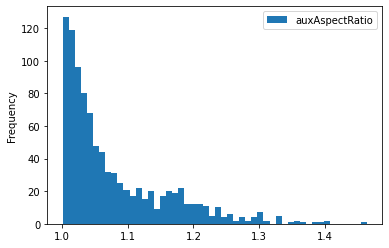

In [16]:
# to do something useful, let's check the mesh quality 
param=doc.getParameter(ifm.Enum.P_AUXDIST_E, 'auxAspectRatio')
v = doc.getParamValues(param)
pd.DataFrame(v, columns=["auxAspectRatio"]).plot.hist(bins=50)

#### Accessing Multispecies-Related Properties

To showcase, we load a different model with multiple species:

In [17]:
# load multi-species example and show content (requires ifm_contrib)
doc = ifm.loadDocument("../data/unittests/models/example_3D_mspecies.fem")
df_species = doc.c.settings.df.species()
df_species

,Name,Type,PhaseType,SpeciesKineticsType
SpeciesID,,,,
0,Sodium,0,0,0
1,Potassium,0,0,0
2,Age1,1,0,0
3,LTE2,2,0,0
4,EP3,3,0,0


In [18]:
# classic usage only allowed to access the first 
doc.setMultiSpeciesId(3)
[doc.getResultsTransportMassValue(n) for n in range(5)]


[0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
# with vectorized new way of adressing the contents, stateless
doc.getParamValues((ifm.Enum.P_PORO, "Potassium"))[:5]

[0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896]

In [20]:
# with vectorized new way of adressing the contents, stateless
doc.getParamValues((ifm.Enum.P_CONC, "Potassium"))[:5]

RuntimeError: GetParamSize: GetParamSize: Invalid parameter id

In [21]:
# to do something useful, let's check that the porosities of all species have same value:
df = pd.DataFrame()
for species in df_species.Name:
    df[species] = doc.getParamValues((ifm.Enum.P_PORO, species))
df.describe()

,Sodium,Potassium,Age1,LTE2,EP3
count,1960.0,1960.0,1960.0,1960.0,1960.0
mean,0.3,0.3,0.3,0.3,0.3
std,0.0,0.0,0.0,0.0,0.0
min,0.3,0.3,0.3,0.3,0.3
25%,0.3,0.3,0.3,0.3,0.3
50%,0.3,0.3,0.3,0.3,0.3
75%,0.3,0.3,0.3,0.3,0.3
max,0.3,0.3,0.3,0.3,0.3


In [22]:
# alternative syntax - getting parameter object first improves speed of many iterations are to be performed
par = doc.getParameter(ifm.Enum.P_CONC, "Potassium") # get the parameter as an object
doc.getParamValues(par)[:5]  # use the object as argument

RuntimeError: GetParamSize: GetParamSize: Invalid parameter id

In [23]:
# alternative syntax - more concise but slower if many loops are required
doc.pdoc.getParamValues((ifm.Enum.P_PORO, "Sodium"))[:5]

[0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896]

#### User Distributions and Expressions

Stateless vectorized access to user distributions.

In [24]:
doc.c.user.df.distributions()

,Name,user_type,item_type,ID
0,MyUserDistribution,DISTRIBUTION,NODAL,0
1,2ndUserDistribution,DISTRIBUTION,NODAL,1
0,MyUserExpression,EXPRESSION,NODAL,0


In [25]:
# unified access to user distribution
doc.getParamValues((ifm.Enum.P_REFDIST_N, "2ndUserDistribution"))[:5]

[2.0, 2.0, 2.0, 2.0, 2.0]

In [26]:
# unified access to user expressions
doc.getParamValues((ifm.Enum.P_EXPDIST_N, "MyUserExpression"))[:5]

[3.0, 3.0, 3.0, 3.0, 3.0]

the same behavior is adopted for the following functions:

+  `getParamSize()`
+  `getParamValue()`
+  `getParamValues()`
+  `setParamValue()`
+  `setParamValues()`
+  `enableParamRecording()`


#### Access to Boundary Conditions
The `doc.getParamValues()` functions now allows to access boundary conditions. Boundary conditions parameter constant are defined in `ifm.Enum`, starting with `ifm.Enum.P_BC*`.

+ `ifm.Enum.P_BC_FLOW`, `ifm.Enum.P_BC_HEAT` and `ifm.Enum.P_BC_MASS` are collective terms for boundary conditions of all kinds,
+ `ifm.Enum.P_BCFLOW_1ST` and similar stands for the specified kind (e.g. 1st kind - Dirichlet-, 2nd kind - Neumann, etc.) of boundary conditions in its basic form, 
+ `ifm.Enum.P_BCFLOW_2ND_GRAD` (Gradient-form) , `ifm.Enum.P_BCFLOW_2ND_INT` (integral form) stand for specific sub-types.

+ `ifm.Enum.P_BCFLOWMOD_1ST` allows to read and write the modulation function related to its given type of boundary conditions.


Full list, please see below:

In [27]:
# this requires documentation
{c: eval("ifm.Enum.{}".format(c)) for c in dir(ifm.Enum) if c.startswith("P_BC")}

{'P_BCFLOWMOD_1ST': 570,
 'P_BCFLOWMOD_2ND': 571,
 'P_BCFLOWMOD_2ND_GRAD': 576,
 'P_BCFLOWMOD_2ND_INT': 574,
 'P_BCFLOWMOD_3RD': 572,
 'P_BCFLOWMOD_3RD_INT': 575,
 'P_BCFLOWMOD_4TH': 573,
 'P_BCFLOW_1ST': 500,
 'P_BCFLOW_2ND': 501,
 'P_BCFLOW_2ND_GRA': 521,
 'P_BCFLOW_2ND_INT': 511,
 'P_BCFLOW_3RD': 502,
 'P_BCFLOW_3RD_INT': 512,
 'P_BCFLOW_4TH': 503,
 'P_BCHEATMOD_1ST': 770,
 'P_BCHEATMOD_2ND': 771,
 'P_BCHEATMOD_2ND_INT': 774,
 'P_BCHEATMOD_3RD': 772,
 'P_BCHEATMOD_3RD_INT': 775,
 'P_BCHEATMOD_4TH': 773,
 'P_BCHEAT_1ST': 700,
 'P_BCHEAT_2ND': 701,
 'P_BCHEAT_2ND_INT': 711,
 'P_BCHEAT_3RD': 702,
 'P_BCHEAT_3RD_INT': 712,
 'P_BCHEAT_4TH': 703,
 'P_BCMASSMOD_1ST': 670,
 'P_BCMASSMOD_2ND': 671,
 'P_BCMASSMOD_2ND_INT': 674,
 'P_BCMASSMOD_3RD': 672,
 'P_BCMASSMOD_3RD_INT': 675,
 'P_BCMASSMOD_4TH': 673,
 'P_BCMASS_1ST': 600,
 'P_BCMASS_2ND': 601,
 'P_BCMASS_2ND_INT': 611,
 'P_BCMASS_3RD': 602,
 'P_BCMASS_3RD_INT': 612,
 'P_BCMASS_4TH': 603,
 'P_BC_FLOW': 500,
 'P_BC_HEAT': 700,
 'P_BC_MASS'

In [28]:
# head BC and Modulation function
doc.c.mesh.df.nodes(par={"HEAD_BC" : ifm.Enum.P_BCFLOW_1ST,
                         "MOD_FUNCTION" : ifm.Enum.P_BCFLOWMOD_1ST}).dropna(subset=["HEAD_BC"])

,SLICE,TOP_NODE,X,Y,HEAD_BC,MOD_FUNCTION
NODE,,,,,,
0,None,None,165.454856,1029.189591,0.0,NaN
1,None,None,136.731283,1003.845262,0.0,NaN
2,None,None,108.007710,978.500933,0.0,NaN
3,None,None,79.284137,953.156604,0.0,NaN
4,None,None,50.560564,927.812275,0.0,NaN
...,...,...,...,...,...,...
1221,None,None,922.190442,523.224622,10.0,NaN
1222,None,None,936.014621,559.996939,10.0,NaN
1223,None,None,949.838801,596.769256,10.0,NaN


## Simulator Settings

### Access Initial Simulation Time

It is now possible to get and set the initial simulation tim:

In [29]:
doc = ifm.loadDocument("../data/unittests/models/example_2D.fem")

In [30]:
# set new initial simulation time
doc.setInitialSimulationTime(5.)
doc.setFinalSimulationTime(20.)

In [31]:
# retrieve initial simulation time
print("Simulation period: {}d - {}d".format(doc.getInitialSimulationTime(), 
                                              doc.pdoc.getFinalSimulationTime()))

Simulation period: 5.0d - 20.0d


### Set Time Stages for DAC saving

It is now possible to set the time steps for dac-file output.

In [32]:
# set the model to save daily time steps
flag = 3
doc.setCustomTimes(list(range(5, 21, 2)), flag)

the flag is for the actual usage of this list:

+ 0: inactive (stored in FEM but not used)
+ 1: used for saving (DAC)
+ 2: used for simulation
+ 3: used for both saving and simulation

Note: 1 and 3 has equal behavior (saving implies simulation), the flag corresponds to the setting of the corresponding checkboxes in FEFLOW.

In [33]:
# this reads the 
doc.queryCustomTimes()

([5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0], 3)

### Results File Control

FEFLOW 7.4 provides provides an improved simulator API.

Changing the output options (dac-path, file type, time of time steps) is now in a seperate call

`doc.setOutput('yyy.dac', ifm.Enum.F_BINARY, [5., 10.])`

before calling one of the simulator calls:

+ `doc.startSimulator()` runs the simulation all the way to the end.
+ `doc.runTo(t_end)` run the simulation until the simulation time reaches *t_end* 
+ `doc.singleStep()` run a single time step

the file type is one of 
+ `ifm.Enum.F_ASCII`
+ `ifm.Enum.F_BINARY`
+ `ifm.Enum.F_CRYPTED`
+ `ifm.Enum.F_DEFAULT`
+ `ifm.Enum.F_INVALID`
+ `ifm.Enum.F_PACKED`
+ `ifm.Enum.F_PROTECTED`
+ `ifm.Enum.F_XML`

The example below first runs the model until day 10 ...

In [34]:
# define the output file
doc.setOutput("test.dac")

# run to simulation time 20 days
doc.runTo(10.)

True

... and then uses single steps until the end of the simuation is reached.

In [35]:
# run in single step mode and use 
while doc.singleStep():
    print(doc.getAbsoluteSimulationTime())

10.42871125029629
10.65072053795304
10.823744070789
10.996767603624958
11.0
11.169791136460917
11.44721145489437
11.780677377414433
12.232925493351479
12.934952444509484
13.0
14.469369651423774
15.0
17.0
19.0
20.0


In [36]:
# check the file steps in resulting dac:
dac = ifm.loadDocument("test.dac")
df_ts = dac.c.sim.df.time_steps()
dac.closeDocument()
df_ts

,step_index,simulation_time,simulation_date,timestep_length
file_index,,,,
0,0,5.0,NaN,0.0
1,21,7.0,NaN,2.0
2,27,9.0,NaN,2.0
3,34,11.0,NaN,2.0
4,40,13.0,NaN,2.0
5,42,15.0,NaN,2.0
6,43,17.0,NaN,2.0
7,44,19.0,NaN,2.0
8,45,20.0,NaN,1.0


## Coordinate Systems Strings

`{set|get}WgeoCoordinateSystem(register).` allows to store a coordinate system string in the fem-file.

**Note**: The string has currently no effect on the model and the FEFLOW GUI, but can be used in scripts for further processing.


**Note**: FEFLOW has multiple registers which can be set independently:

+ `CS_AUTHSTR`, e.g. "epsg:32632"
+ `CS_CRSWKT`
+ `CS_JSON`
+ `CS_PRJFILE`
+ `CS_PROJ`
+ `CS_WGEO`

See https://spatialreference.org/ for more examples.

**Note**: future applications will require that only one register is allowed at a time. This condition must be checked by the client script.


In [37]:
# set to WGS84 / UTM zone 32N
doc.setGeoCoordinateSystem(ifm.Enum.CS_AUTHSTR, "epsg:32632")

In [38]:
# get the coordinate string
doc.getGeoCoordinateSystem(ifm.Enum.CS_AUTHSTR)

'epsg:32632'

## Pathlines and Streamlines

IFM API 7.4 includes a complete API to compute pathlines and streamlines (!).


The example below illustrates its usage:

In [39]:
doc = ifm.loadDocument("../data/unittests/models/example_2D.dac")

In [40]:
# First, create particle tracer object
pt=doc.createParticleTracer()

In [41]:
# Tracking Direction - forward vs. backward
# pt.setTrackingDirection(ifm.Enum.PT_BACKWARD)  # backward lines
pt.setTrackingDirection(ifm.Enum.PT_FORWARD)  # forward lines

In [42]:
# Tracking Mode - streamline vs. pathline
# pt.setTrackingMode(ifm.Enum.PT_UNSTEADY) # pathlines
pt.setTrackingMode(ifm.Enum.PT_STEADY) # streamlines

In [43]:
# Tracking Type - classic tracking vs. random walk
# pt.setTrackingType(ifm.Enum.PT_RW)  # random-walk streamlines/pathlines
pt.setTrackingType(ifm.Enum.PT_ADVECTIVE)  # classic streamlines/pathlines

In [44]:
# Travel time period (Initial to Final) to for tracking operation
pt.setInitialTime(0)  
pt.setFinalTime(365.24 * 100)

In [ ]:
Renaming

# type
('PT_TYPE_ADVECTIVE', 0), 
('PT_TYPE_RW', 1),

# direction
('PT_DIR_FORWARD', 0),
('PT_DIR_BACKWARD', 1),

# mode
('PT_MODE_STEADY', 0),
('PT_MODE_UNSTEADY', 1)]

# dispersion type (muss nicht geändert werden)
('PT_DISP_FICKIAN', 0)
('PT_DISP_T_DEPENDS', 1),
('PT_DISP_D_DEPENDS', 2),

# RW Method
('PT_MET_BACKWARDITO', 1),
('PT_MET_STRATONOVICH', 2),
('PT_MET_RK3ITO', 3),
('PT_MET_FORWARDITO', 4),


A single pathline is now calculated using `pt.generatePathLine(X, Y)`, where `X` and `Y` are the coordinates of the seed point. The function returns a list of tuples (`x`, `y`, `tau`), where `x`and `y` are the coordinates and `tau` is the travel time of each line vertex.

In [46]:
pl=pt.generatePathLine(500., 500.)
pl[::100] # show every 100th vertex

[(500.0, 500.0, 0.0),
 (493.48087762336604, 658.8290937522285, 5040355.410213804),
 (493.4808621193339, 658.8290940125363, 13687405.808231473),
 (493.4808621341816, 658.8290940122868, 22334616.895355653),
 (493.4808621342072, 658.8290940122868, 30981827.822169736),
 (493.4808621342102, 658.8290940122852, 39629038.7487041)]

The ParticleTracer object allows to {get|set} all computation settings for the pathline computation:

   `getAAxis_pitchParameter`,`getAAxis_pitchValue`,`getAAxis_yawParameter`,
   `getAAxis_yawValue`,`getAquiferThickness`,`getCompressionEnabled`,
   `getDiffCoeffParameter`,`getDiffCoeffValue`,`getFinalTime`,`getInitialTime`,
   `getLongDispParameter`,`getLongDispValue`,`getLongDisp_mParameter`,
   `getLongDisp_mValue`,`getPorosityParameter`,`getPorosityValue`,
   `getRandomWalkMethod`,`getRkAccuracy`,`getRkMaxElementSwitches`,
   `getRkMaxStepsPerElement`,`getRkMinStepSizeFactor`,`getRkMinStepTime`,
   `getScaleDepDispDref`,`getScaleDepDispTref`,`getSorptionParameter`,
   `getTransvDispParameter`,`getTransvDispValue`,`getTransvDisp_mParameter`,
   `getTransvDisp_mValue`
   
See [dhi.github.io/ifm](dhi.github.io/ifm) for the documentation. 
   
In most cases, default settings are sufficient, which can be (re-) set with the following command:

In [47]:
# use default the setting (not necessary)
pt.setDefaults()

<div class="alert alert-danger" role="alert">
    
Final time seems to be ignored!
    
</div>

A pathline swarm is created by running this in a loop for multiple points. The following examples does this for each point of an inflowing border 

from an inflowing border, a single pathline is produced per node:

In [49]:
# get node numbers and coordinates
df_selections = doc.c.sel.df.selections()
df_nodes = doc.c.mesh.df.nodes()

Text(0.5, 1.0, 'Forward Streamlines')

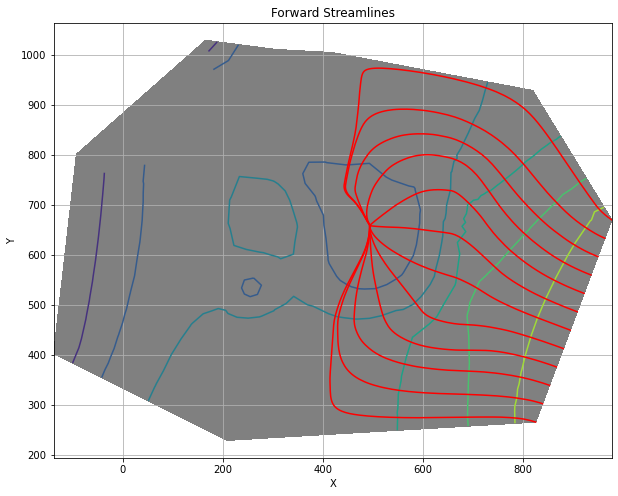

In [50]:
# create a plot
fig, ax1 = plt.subplots(1, figsize=(10,8))
ax1.axis("equal")
doc.c.plot.faces()
doc.c.plot.isolines(par=ifm.Enum.P_HEAD)
ax1.grid()
ax1.set_ylabel("Y")
ax1.set_xlabel("X")

# add pathlines starting from the selection "east"
for n in doc.c.sel.list("east"):
    pl=pt.generatePathLine(df_nodes.X[n], df_nodes.Y[n])
    df_pl = pd.DataFrame(pl, columns=["X", "Y", "Tau"])
    plt.plot(df_pl.X, df_pl.Y, color="red")

plt.title("Forward Streamlines")
# for a FEFLOW style visualization, see https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html 

Text(0.5, 1.0, 'Forward Random-Walk')

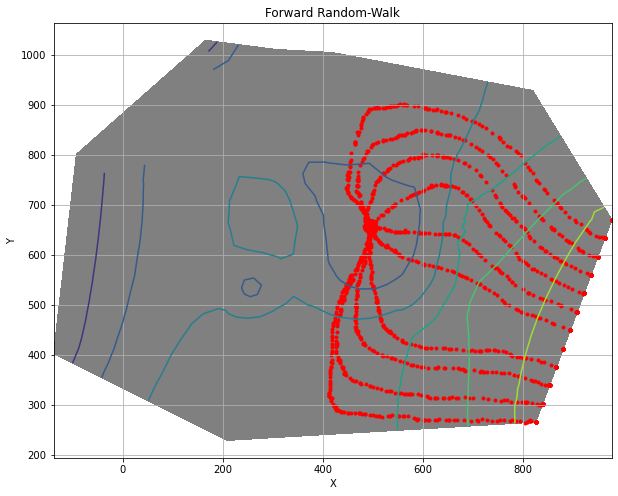

In [51]:
# repeat for random walk

pt.setTrackingType(ifm.Enum.PT_RW)  # random-walk streamlines/pathlines

# create a plot
fig, ax1 = plt.subplots(1, figsize=(10,8))
ax1.axis("equal")
doc.c.plot.faces()
doc.c.plot.isolines(par=ifm.Enum.P_HEAD)
ax1.grid()
ax1.set_ylabel("Y")
ax1.set_xlabel("X")

# add pathlines starting from the selection "east"
for n in doc.c.sel.list("east"):
    pl=pt.generatePathLine(df_nodes.X[n], df_nodes.Y[n])
    df_pl = pd.DataFrame(pl, columns=["X", "Y", "Tau"])
    plt.scatter(df_pl.X, df_pl.Y, marker=".", color="red")
    
plt.title("Forward Random-Walk")
